In [1]:
from torch import empty, zeros, cat
from tqdm.notebook import tqdm

from torchkge.data_structures import SmallKG
from torchkge.exceptions import NotYetEvaluatedError
from torchkge.sampling import PositionalNegativeSampler
from torchkge.utils import DataLoader
import pandas as pd
import torch
import torch
import os
from os.path import join
# from evaluation import TemporalLinkPredictionEvaluator

from torchkge.utils import datasets
import torch
from pandas import read_csv, concat
import json
from datetime import datetime
import pandas as pd

from torchkge.utils import datasets
import torch
from pandas import read_csv, concat
# from data_utils import TemporalKnowledgeGraph
from numpy.random import RandomState

from torch import tensor, bernoulli, randint, ones, rand, cat
from torchkge.utils import init_embedding
from torch.nn.functional import normalize
import torch.nn.functional as F
import itertools

from datetime import datetime, time, timedelta

In [2]:
import shutil

from os import environ, makedirs
from os.path import exists, expanduser, join
from torch.utils.data import Dataset
from torchkge.exceptions import SizeMismatchError, WrongArgumentsError, SanityError
from torchkge.utils.operations import get_dictionaries
from torch import cat, eq, int64, long, randperm, tensor, Tensor, zeros_like
from collections import defaultdict
from pandas import DataFrame
import torch
# from utils import get_temporal_dictionaries
from pandas import read_csv, concat

In [3]:
from os.path import join
import torch
from torch import cuda
from torch.optim import Adam
from torchkge.sampling import BernoulliNegativeSampler, UniformNegativeSampler
from tqdm.notebook import tqdm
import pandas as pd
import os


In [4]:
from torchkge.utils import MarginLoss, BinaryCrossEntropyLoss, LogisticLoss
import torch
import torch.distributed as dist
from abc import ABC, abstractmethod
import torch.distributed as dist
import torch.nn as nn

import numpy as np

In [5]:
from torch.nn import Module


from torchkge.utils.dissimilarities import l1_dissimilarity, l2_dissimilarity, \
    l1_torus_dissimilarity, l2_torus_dissimilarity, el2_torus_dissimilarity

In [6]:
from collections import defaultdict

from torch import tensor, bernoulli, randint, ones, rand, cat

from torchkge.exceptions import NotYetImplementedError
from torchkge.utils.data import DataLoader
from torchkge.utils.operations import get_bernoulli_probs


In [7]:
import torch
device = torch.device("cuda:1" if torch.cuda.is_available() else "cpu")
# device = 'cpu'

## Utils

In [8]:

tem_dict = {
    '0y': 0, '1y': 1, '2y': 2, '3y': 3, '4y': 4, '5y': 5, '6y': 6, '7y': 7, '8y': 8, '9y': 9,
    '0m': 10, '1m': 11, '2m': 12, '3m': 13, '4m': 14, '5m': 15, '6m': 16, '7m': 17, '8m': 18, '9m': 19,
    '0d': 20, '1d': 21, '2d': 22, '3d': 23, '4d': 24, '5d': 25, '6d': 26, '7d': 27, '8d': 28, '9d': 29
}

class Params():
    def __init__(self):
        pass


def get_expriment_tests(results):
    res = []
    for exp in results:
        train_params = exp['train_params']
        test_results = exp['test_results']
        train_params.update(test_results)
        res.append(train_params)
    return pd.DataFrame(res)

def read_json_lines(file_name):
    lines = []
    with open(file_name) as file_in:
        for line in file_in:
            lines.append(json.loads(line))
    return lines

def write_json_lines(file_name,dict_data):
    json_string = json.dumps(dict_data)
    with open(file_name, 'a') as f:
        f.write(json_string+"\n")

def experiment_exists(all_exp_data_df, exp_data_dict, important_fields = None):
    if important_fields is None:
        search_keys = exp_data_dict
    else:
        search_keys = important_fields
    for k in search_keys:
        all_exp_data_df = all_exp_data_df[all_exp_data_df[k]==exp_data_dict[k]]
        if all_exp_data_df.shape[0]==0:
            return False
    return True

def check_experiment(exp_file_name):
    res = read_json_lines(exp_file_name)
    res = get_expriment_tests(res)
    return res

def transform_time_V2(years, months, days):
    all_data = []
    for year, month, day in zip(years, months, days):
        tem_id_list = []
        for j in range(len(year)):
            token = year[j:j+1]+'y'
            tem_id_list.append(tem_dict[token])
        # print(tem_id_list)
        # exit()

        for j in range(1):
            # print(month[1])
            # exit()
            token1 = month[0]+'m'
            tem_id_list.append(tem_dict[token1])
            token2 = month[0]+'m'
            tem_id_list.append(tem_dict[token2])


        for j in range(len(day)):
            token = day[j:j+1]+'d'
            tem_id_list.append(tem_dict[token])
            
        all_data.append(torch.tensor(tem_id_list))
    return all_data

def transform_time(raw_time):
    year, month, day = raw_time.split("-")
    tem_id_list = []
    for j in range(len(year)):
        token = year[j:j+1]+'y'
        tem_id_list.append(tem_dict[token])
    # print(tem_id_list)
    # exit()

    for j in range(1):
        # print(month[1])
        # exit()
        token1 = month[0]+'m'
        tem_id_list.append(tem_dict[token1])
        token2 = month[0]+'m'
        tem_id_list.append(tem_dict[token2])


    for j in range(len(day)):
        token = day[j:j+1]+'d'
        tem_id_list.append(tem_dict[token])
    return tem_id_list

def transform_time_v3(raw_time):
    date = list(map(float, raw_time.split("-")))
    return date

def transform_time_v4(raw_time):
    year, month, day = raw_time.split("-")
    year, month, day = int(year), int(month), int(day)
    return month + day

def transform_time_v5(raw_time):
    year, month, day = raw_time.split("-")
    return [int(year), int(month), int(day)]

def get_temporal_dictionaries(df, mode='simple'):

    tmp = list(set(df['start_time'].unique()).union(set(df['end_time'].unique())))
    if mode == 'simple_time':
        # return {timee: i for i, timee in enumerate(sorted(tmp))}
        idx = {timee: i for i, timee in enumerate(sorted([datetime.strptime(dt, "%Y-%m-%d") for dt in tmp]))}
        time_trans = torch.tensor(list(idx.values()))
        return idx, time_trans
    elif mode == 'simple':
        # return {timee: i for i, timee in enumerate(sorted(tmp))}
        idx = {timee: i for i, timee in enumerate(sorted([dt for dt in tmp]))}
        time_trans = torch.tensor(list(idx.values()))
        return idx, time_trans
    elif mode == 'seq':
        idx = {timee: i for i, timee in enumerate(sorted(tmp))}
        time_trans = torch.vstack([torch.tensor(transform_time(timee)) for timee in sorted(tmp)])
        return idx, time_trans
        # return {timee: torch.tensor(transform_time(timee)) for i, timee in enumerate(sorted([datetime.strptime(dt, "%Y-%m-%d") for dt in tmp]))}
    elif mode == 'ymd':
        idx = {timee: transform_time_v4(timee) for i, timee in enumerate(sorted(tmp))}
        time_trans = torch.vstack([transform_time_v4(timee) for timee in sorted(tmp)])
        return 
    elif mode == 'ymd_':
#         idx = {timee: torch.tensor(transform_time_v5(timee)) for i, timee in enumerate(sorted(tmp))}
        idx = {timee: i for i, timee in enumerate(sorted(tmp))}
        time_trans = torch.vstack([torch.tensor(transform_time_v5(timee)) for timee in sorted(tmp)])
        return idx, time_trans

def cconv(a, b):
    return torch.fft.ifft(torch.fft.fft(a) * torch.fft.fft(b)).real


def ccorr(a, b):
    return torch.fft.ifft(torch.conj(torch.fft.fft(a)) * torch.fft.fft(b)).real


##  Data Utils

In [9]:
class TemporalKnowledgeGraph(Dataset):

    def __init__(self, df=None, time_mode = None,kg=None, ent2ix=None, rel2ix=None, time2ix = None,
                 time_trans = None,
                 dict_of_heads=None, dict_of_tails=None, dict_of_rels=None,
                 temp_dict_of_heads=None, temp_dict_of_tails=None, temp_dict_of_rels=None):

        if df is None:
            if kg is None:
                raise WrongArgumentsError("Please provide at least one "
                                          "argument of `df` and kg`")
            else:
                try:
                    assert (type(kg) == dict) & ('heads' in kg.keys()) & \
                           ('tails' in kg.keys()) & \
                           ('relations' in kg.keys())& \
                            ('start_time' in kg.keys())& \
                            ('end_time' in kg.keys())
                    
                except AssertionError:
                    raise WrongArgumentsError("Keys in the `kg` dict should "
                                              "contain `heads`, `tails`, "
                                              "`relations`.")
                try:
                    assert (rel2ix is not None) & (ent2ix is not None)
                except AssertionError:
                    raise WrongArgumentsError("Please provide the two "
                                              "dictionaries ent2ix and rel2ix "
                                              "if building from `kg`.")
        else:
            if kg is not None:
                raise WrongArgumentsError("`df` and kg` arguments should not "
                                          "both be provided.")

        if ent2ix is None:
            self.ent2ix = get_dictionaries(df, ent=True)
        else:
            self.ent2ix = ent2ix

        if rel2ix is None:
            self.rel2ix = get_dictionaries(df, ent=False)
        else:
            self.rel2ix = rel2ix
            
        if time_mode is not None:
            self.time_mode = time_mode
            
        if time2ix is None:
            self.time2ix, self.time_trans = get_temporal_dictionaries(df, mode = self.time_mode)
        else:
            self.time2ix, self.time_trans = time2ix, time_trans
        
        self.n_ent = max(self.ent2ix.values()) + 1
        self.n_rel = max(self.rel2ix.values()) + 1
        time_val = list(self.time2ix.values())
        
        if isinstance(time_val[0], torch.Tensor):
            self.n_time = int(torch.cat(time_val).max()) + 1
        else: 
            self.n_time = max(time_val) + 1
            
#         print('self.n_time: ',self.n_time)
        if df is not None:
            # build kg from a pandas dataframe
            self.n_facts = len(df)
            self.head_idx = tensor(df['from'].map(self.ent2ix).values).long()
            self.tail_idx = tensor(df['to'].map(self.ent2ix).values).long()
            self.relations = tensor(df['rel'].map(self.rel2ix).values).long()
#             self.start_time = tensor(df['start_time'].map(self.rel2ix).values).long()
#             self.end_time = tensor(df['end_time'].map(self.rel2ix).values).long()
#             print(self.time2ix)
            self.start_time = list(df['start_time'].map(self.time2ix).values)
#             print(self.start_time)
#             print('-'*22)
#             print("type(self.start_time[0]): ",type(self.start_time[0]))
#             print('type(self.start_time): ',type(self.start_time))
#             if isinstance(self.start_time[0], torch.Tensor):
#                 print('llllll')
            if isinstance(self.start_time, list) & isinstance(self.start_time[0], torch.Tensor):
                self.start_time = torch.stack(self.start_time)
            else:
                self.start_time = torch.tensor(self.start_time)
            
            self.start_time = self.start_time.long()
            
            self.end_time = list(df['end_time'].map(self.time2ix).values)
            if isinstance(self.end_time, list) & isinstance(self.end_time[0], torch.Tensor):
                self.end_time = torch.stack(self.end_time)
            else:
                self.end_time = torch.tensor(self.end_time)   
            self.end_time = self.end_time.long()
            
        else:
            # build kg from another kg
            self.n_facts = kg['heads'].shape[0]
            self.head_idx = kg['heads']
            self.tail_idx = kg['tails']
            self.relations = kg['relations']
            self.start_time = kg['start_time']
            self.end_time = kg['end_time']

        if dict_of_heads is None or dict_of_tails is None or dict_of_rels is None:
            self.dict_of_heads = defaultdict(set)
            self.dict_of_tails = defaultdict(set)
            self.dict_of_rels = defaultdict(set)
            self.temp_dict_of_heads = defaultdict(set)
            self.temp_dict_of_tails = defaultdict(set)
            self.temp_dict_of_rels = defaultdict(set)
#             self.dict_of_start_time = defaultdict(set)
#             self.dict_of_end_time = defaultdict(set)
            self.evaluate_dicts()

        else:
            self.dict_of_heads = dict_of_heads
            self.dict_of_tails = dict_of_tails
            self.dict_of_rels = dict_of_rels
            self.temp_dict_of_heads = temp_dict_of_heads
            self.temp_dict_of_tails = temp_dict_of_tails
            self.temp_dict_of_rels = temp_dict_of_rels
#             self.dict_of_start_time = dict_of_start_time
#             self.dict_of_end_time = dict_of_end_time
        try:
            self.sanity_check()
        except AssertionError:
            raise SanityError("Please check the sanity of arguments.")

    def __len__(self):
        return self.n_facts

    def __getitem__(self, item):
        return (self.head_idx[item].item(),
                self.tail_idx[item].item(),
                self.relations[item].item())

    def sanity_check(self):
        assert (type(self.dict_of_heads) == defaultdict) & \
               (type(self.dict_of_tails) == defaultdict) & \
               (type(self.dict_of_rels) == defaultdict) & \
                (type(self.temp_dict_of_heads) == defaultdict) & \
               (type(self.temp_dict_of_tails) == defaultdict) & \
               (type(self.temp_dict_of_rels) == defaultdict)
        assert (type(self.ent2ix) == dict) & (type(self.rel2ix) == dict)
        assert (len(self.ent2ix) == self.n_ent) & \
               (len(self.rel2ix) == self.n_rel)
        assert (type(self.head_idx) == Tensor) & \
               (type(self.tail_idx) == Tensor) & \
               (type(self.relations) == Tensor)
        assert (self.head_idx.dtype == int64) & \
               (self.tail_idx.dtype == int64) & (self.relations.dtype == int64)
        assert (len(self.head_idx) == len(self.tail_idx) == len(self.relations))

    def split_kg(self, share=0.8, sizes=None, validation=False):
        if sizes is not None:
            try:
                if len(sizes) == 3:
                    try:
                        assert (sizes[0] + sizes[1] + sizes[2] == self.n_facts)
                    except AssertionError:
                        raise WrongArgumentsError('Sizes should sum to the '
                                                  'number of facts.')
                elif len(sizes) == 2:
                    try:
                        assert (sizes[0] + sizes[1] == self.n_facts)
                    except AssertionError:
                        raise WrongArgumentsError('Sizes should sum to the '
                                                  'number of facts.')
                else:
                    raise SizeMismatchError('Tuple `sizes` should be of '
                                            'length 2 or 3.')
            except AssertionError:
                raise SizeMismatchError('Tuple `sizes` should sum up to the '
                                        'number of facts in the knowledge '
                                        'graph.')
        else:
            assert share < 1

        if ((sizes is not None) and (len(sizes) == 3)) or \
                ((sizes is None) and validation):
            # return training, validation and a testing graphs

            if (sizes is None) and validation:
                mask_tr, mask_val, mask_te = self.get_mask(share,
                                                           validation=True)
            else:
                mask_tr = cat([tensor([1 for _ in range(sizes[0])]),
                               tensor([0 for _ in range(sizes[1] + sizes[2])])]).bool()
                mask_val = cat([tensor([0 for _ in range(sizes[0])]),
                                tensor([1 for _ in range(sizes[1])]),
                                tensor([0 for _ in range(sizes[2])])]).bool()
                mask_te = ~(mask_tr | mask_val)

            return (TemporalKnowledgeGraph(
                        kg={'heads': self.head_idx[mask_tr],
                            'tails': self.tail_idx[mask_tr],
                            'relations': self.relations[mask_tr],
                           'start_time': self.start_time[mask_tr],
                           'end_time': self.end_time[mask_tr]},
                            ent2ix=self.ent2ix, rel2ix=self.rel2ix, time2ix = self.time2ix,
                            time_trans = self.time_trans,
                            dict_of_heads=self.dict_of_heads,
                            dict_of_tails=self.dict_of_tails,
                            dict_of_rels=self.dict_of_rels,
                            temp_dict_of_heads = self.temp_dict_of_heads,
                            temp_dict_of_tails = self.temp_dict_of_tails,
                            temp_dict_of_rels = self.temp_dict_of_rels
                            ),
                    TemporalKnowledgeGraph(
                        kg={'heads': self.head_idx[mask_val],
                            'tails': self.tail_idx[mask_val],
                            'relations': self.relations[mask_val],
                           'start_time':  self.start_time[mask_val],
                           'end_time': self.end_time[mask_val]},
                        ent2ix=self.ent2ix, rel2ix=self.rel2ix, time2ix = self.time2ix,
                        time_trans = self.time_trans,
                        dict_of_heads=self.dict_of_heads,
                        dict_of_tails=self.dict_of_tails,
                        dict_of_rels=self.dict_of_rels,
                        temp_dict_of_heads = self.temp_dict_of_heads,
                        temp_dict_of_tails = self.temp_dict_of_tails,
                        temp_dict_of_rels = self.temp_dict_of_rels),
                    TemporalKnowledgeGraph(
                        kg={'heads': self.head_idx[mask_te],
                            'tails': self.tail_idx[mask_te],
                            'relations': self.relations[mask_te],
                           'start_time': self.start_time[mask_te],
                           'end_time': self.end_time[mask_te]},
                        ent2ix=self.ent2ix, rel2ix=self.rel2ix, time2ix = self.time2ix,
                        time_trans = self.time_trans,
                        dict_of_heads=self.dict_of_heads,
                        dict_of_tails=self.dict_of_tails,
                        dict_of_rels=self.dict_of_rels,
                        temp_dict_of_heads = self.temp_dict_of_heads,
                        temp_dict_of_tails = self.temp_dict_of_tails,
                        temp_dict_of_rels = self.temp_dict_of_rels
                        ))
        else:
            # return training and testing graphs

            assert (((sizes is not None) and len(sizes) == 2) or
                    ((sizes is None) and not validation))
            if sizes is None:
                mask_tr, mask_te = self.get_mask(share, validation=False)
            else:
                mask_tr = cat([tensor([1 for _ in range(sizes[0])]),
                               tensor([0 for _ in range(sizes[1])])]).bool()
                mask_te = ~mask_tr
            return (TemporalKnowledgeGraph(
                        kg={'heads': self.head_idx[mask_tr],
                            'tails': self.tail_idx[mask_tr],
                            'relations': self.relations[mask_tr],
                           'start_time': self.start_time[mask_tr],
                           'end_time': self.end_time[mask_tr]},
                        ent2ix=self.ent2ix, rel2ix=self.rel2ix, time2ix = self.time2ix,
                        time_trans = self.time_trans,
                        dict_of_heads=self.dict_of_heads,
                        dict_of_tails=self.dict_of_tails,
                        dict_of_rels=self.dict_of_rels,
                        temp_dict_of_heads = self.temp_dict_of_heads,
                        temp_dict_of_tails = self.temp_dict_of_tails,
                        temp_dict_of_rels = self.temp_dict_of_rels
                        ),
                    TemporalKnowledgeGraph(
                        kg={'heads': self.head_idx[mask_te],
                            'tails': self.tail_idx[mask_te],
                            'relations': self.relations[mask_te],
                           'start_time': self.start_time[mask_te],
                           'end_time': self.end_time[mask_te]},
                        ent2ix=self.ent2ix, rel2ix=self.rel2ix, time2ix = self.time2ix,
                        time_trans = self.time_trans,
                        dict_of_heads=self.dict_of_heads,
                        dict_of_tails=self.dict_of_tails,
                        dict_of_rels=self.dict_of_rels,
                        temp_dict_of_heads = self.temp_dict_of_heads,
                        temp_dict_of_tails = self.temp_dict_of_tails,
                        temp_dict_of_rels = self.temp_dict_of_rels
                        ))

    def get_mask(self, share, validation=False):

        uniques_r, counts_r = self.relations.unique(return_counts=True)
        uniques_e, _ = cat((self.head_idx,
                            self.tail_idx)).unique(return_counts=True)

        mask = zeros_like(self.relations).bool()
        if validation:
            mask_val = zeros_like(self.relations).bool()

        # splitting relations among subsets
        for i, r in enumerate(uniques_r):
            rand = randperm(counts_r[i].item())

            # list of indices k such that relations[k] == r
            sub_mask = eq(self.relations, r).nonzero(as_tuple=False)[:, 0]

            assert len(sub_mask) == counts_r[i].item()

            if validation:
                train_size, val_size, test_size = self.get_sizes(counts_r[i].item(),
                                                                 share=share,
                                                                 validation=True)
                mask[sub_mask[rand[:train_size]]] = True
                mask_val[sub_mask[rand[train_size:train_size + val_size]]] = True

            else:
                train_size, test_size = self.get_sizes(counts_r[i].item(),
                                                       share=share,
                                                       validation=False)
                mask[sub_mask[rand[:train_size]]] = True

        # adding missing entities to the train set
        u = cat((self.head_idx[mask], self.tail_idx[mask])).unique()
        if len(u) < self.n_ent:
            missing_entities = tensor(list(set(uniques_e.tolist()) -
                                           set(u.tolist())), dtype=long)
            for e in missing_entities:
                sub_mask = ((self.head_idx == e) |
                            (self.tail_idx == e)).nonzero(as_tuple=False)[:, 0]
                rand = randperm(len(sub_mask))
                sizes = self.get_sizes(mask.shape[0],
                                       share=share,
                                       validation=validation)
                mask[sub_mask[rand[:sizes[0]]]] = True
                if validation:
                    mask_val[sub_mask[rand[:sizes[0]]]] = False

        if validation:
            assert not (mask & mask_val).any().item()
            return mask, mask_val, ~(mask | mask_val)
        else:
            return mask, ~mask

    @staticmethod
    def get_sizes(count, share, validation=False):
        if count == 1:
            if validation:
                return 1, 0, 0
            else:
                return 1, 0
        if count == 2:
            if validation:
                return 1, 1, 0
            else:
                return 1, 1

        n_train = int(count * share)
        assert n_train < count
        if n_train == 0:
            n_train += 1

        if not validation:
            return n_train, count - n_train
        else:
            if count - n_train == 1:
                n_train -= 1
                return n_train, 1, 1
            else:
                n_val = int(int(count - n_train) / 2)
                return n_train, n_val, count - n_train - n_val

    def evaluate_dicts(self):
        for i in range(self.n_facts):
            self.dict_of_heads[(self.tail_idx[i].item(),
                                self.relations[i].item())].add(self.head_idx[i].item())
            self.dict_of_tails[(self.head_idx[i].item(),
                                self.relations[i].item())].add(self.tail_idx[i].item())
            self.dict_of_rels[(self.head_idx[i].item(),
                               self.tail_idx[i].item())].add(self.relations[i].item())
            
            self.temp_dict_of_heads[(self.tail_idx[i].item(),
                                    self.relations[i].item(),
                                     self.start_time[i].item(),
                                     self.end_time[i].item())].add(self.head_idx[i].item())
            self.temp_dict_of_tails[(self.head_idx[i].item(),
                                self.relations[i].item(),
                                     self.start_time[i].item(),
                                     self.end_time[i].item())].add(self.tail_idx[i].item())
            self.temp_dict_of_rels[(self.head_idx[i].item(),
                                   self.tail_idx[i].item(),
                                    self.start_time[i].item(),
                                     self.end_time[i].item())].add(self.relations[i].item())

    def get_df(self):
        ix2ent = {v: k for k, v in self.ent2ix.items()}
        ix2rel = {v: k for k, v in self.rel2ix.items()}

        df = DataFrame(cat((self.head_idx.view(1, -1),
                            self.tail_idx.view(1, -1),
                            self.relations.view(1, -1))).transpose(0, 1).numpy(),
                       columns=['from', 'to', 'rel'])

        df['from'] = df['from'].apply(lambda x: ix2ent[x])
        df['to'] = df['to'].apply(lambda x: ix2ent[x])
        df['rel'] = df['rel'].apply(lambda x: ix2rel[x])

        return df


class SmallKG(Dataset):
    def __init__(self, heads, tails, relations):
        assert heads.shape == tails.shape == relations.shape
        self.head_idx = heads
        self.tail_idx = tails
        self.relations = relations
        self.length = heads.shape[0]

    def __len__(self):
        return self.length

    def __getitem__(self, item):
        return self.head_idx[item].item(), self.tail_idx[item].item(), self.relations[item].item()



def get_data_home(data_home=None):
    if data_home is None:
        data_home = environ.get('TORCHKGE_DATA',
                                join('~', 'torchkge_data'))
    data_home = expanduser(data_home)
    if not exists(data_home):
        makedirs(data_home)
    return data_home


def clear_data_home(data_home=None):
    data_home = get_data_home(data_home)
    shutil.rmtree(data_home)


def get_n_batches(n, b_size):
    n_batch = n // b_size
    if n % b_size > 0:
        n_batch += 1
    return n_batch


class TempDataLoader:
    """This class is inspired from :class:`torch.utils.dataloader.DataLoader`.
    It is however way simpler.

    """
    def __init__(self, kg, batch_size, use_cuda=None):

        self.h = kg.head_idx
        self.t = kg.tail_idx
        self.r = kg.relations
        self.start_time = kg.start_time
        self.end_time = kg.end_time

        self.use_cuda = use_cuda
        self.batch_size = batch_size

        self.h = self.h.to(device)
        self.t = self.t.to(device)
        self.r = self.r.to(device)
        self.start_time = self.start_time.to(device)
        self.end_time = self.end_time.to(device)
            
    def __len__(self):
        return get_n_batches(len(self.h), self.batch_size)

    def __iter__(self):
        return _TempDataLoaderIter(self)


class _TempDataLoaderIter:
    def __init__(self, loader):
        self.h = loader.h
        self.t = loader.t
        self.r = loader.r
        self.start_time = loader.start_time
        self.end_time = loader.end_time
        
        self.use_cuda = loader.use_cuda
        self.batch_size = loader.batch_size

        self.n_batches = get_n_batches(len(self.h), self.batch_size)
        self.current_batch = 0

    def __next__(self):
        if self.current_batch == self.n_batches:
            raise StopIteration
        else:
            i = self.current_batch
            self.current_batch += 1

            tmp_h = self.h[i * self.batch_size: (i + 1) * self.batch_size]
            tmp_t = self.t[i * self.batch_size: (i + 1) * self.batch_size]
            tmp_r = self.r[i * self.batch_size: (i + 1) * self.batch_size]
            tmp_start_time = self.start_time[i * self.batch_size: (i + 1) * self.batch_size]
            tmp_end_time = self.end_time[i * self.batch_size: (i + 1) * self.batch_size]
            return tmp_h.to(device), tmp_t.to(device), tmp_r.to(device), tmp_start_time.to(device), tmp_end_time.to(device)

    def __iter__(self):
        return self


## Datasets

In [10]:
def load_edukg(data_home=None, time_mode=None):
    data_path = data_home + '/edukg'
    ent_df = pd.read_csv(data_path + '/entity2id.txt', sep='\t',
                         header=None, names=['ent', 'id'])
    # print('ent_df.dtypes: ',ent_df.dtypes)
    rel_df = pd.read_csv(data_path + '/relation2id.txt', sep='\t',
                         header=None, names=['rel', 'id'])
    # print('rel_df.dtypes: ',rel_df.dtypes)
    ent_df = dict(zip(ent_df['ent'], ent_df['id']))
    rel_df = dict(zip(rel_df['rel'], rel_df['id']))
    
    df1 = read_csv(data_path + '/train.txt',
                   sep='\t', header=None, names=['from', 'rel', 'to', 'start_time', 'end_time'])
    df1['end_time'] = df1['start_time']
    # print(df1)
    # print(df1.isna().any())
    # print('df1.dtypes: ',df1.dtypes)
    df2 = read_csv(data_path + '/val.txt',
                   sep='\t', header=None, names=['from', 'rel', 'to', 'start_time', 'end_time'])
    df2['end_time'] = df2['start_time']
    # print('df2.dtypes: ',df2.dtypes)
    df3 = read_csv(data_path + '/test.txt',
                   sep='\t', header=None, names=['from', 'rel', 'to', 'start_time', 'end_time'])
    df3['end_time'] = df3['start_time']
    # print('df3.dtypes: ',df3.dtypes)
    df = concat([df1, df2, df3])
    kg = TemporalKnowledgeGraph(df, time_mode = time_mode, ent2ix=ent_df, rel2ix=rel_df)

    return kg.split_kg(sizes=(len(df1), len(df2), len(df3)))



def get_data(data_name, time_mode):
    if data_name == 'edukg':
        return load_edukg(data_home='data', time_mode=time_mode)
    else:
        datas = ['edukg']
        
        print('Choose One of the Following Datasets: ',datas)


## Eval Utils

In [11]:
def get_true_targets(dictionary, key1, key2, key3, key4, true_idx, i):
    try:
        if key4 is not None:
            true_targets = dictionary[key1[i].item(), key2[i].item(), key3[i].item(), key4[i].item()].copy()
        else:
            true_targets = dictionary[key1[i].item(), key2[i].item(), key3[i].item()].copy()
            
        if true_idx is not None:
            true_targets.remove(true_idx[i].item())
            if len(true_targets) > 0:
                return tensor(list(true_targets)).long()
            else:
                return None
        else:
            return tensor(list(true_targets)).long()
    except KeyError:
        return None

In [12]:
# filter_scores(scores, self.kg.dict_of_tails, h_idx, r_idx, t_idx, start_time, end_time)
def filter_scores(scores, dictionary, key1, key2, key3, key4, true_idx):
    # filter out the true negative samples by assigning - inf score.
    b_size = scores.shape[0]
    filt_scores = scores.clone()

    for i in range(b_size):
        true_targets = get_true_targets(dictionary, key1, key2, key3, key4, true_idx, i)
        if true_targets is None:
            continue
        filt_scores[i][true_targets] = - float('Inf')

    return filt_scores


In [13]:
def get_rank(data, true, low_values=False):
    true_data = data.gather(1, true.long().view(-1, 1))

    if low_values:
        return (data <= true_data).sum(dim=1)
    else:
        return (data >= true_data).sum(dim=1)

## Evaluation

In [14]:
class TemporalLinkPredictionEvaluator(object):

    def __init__(self, model, knowledge_graph):
        self.model = model
        self.kg = knowledge_graph

        self.rank_true_heads = empty(size=(knowledge_graph.n_facts,)).long()
        self.rank_true_tails = empty(size=(knowledge_graph.n_facts,)).long()
        self.filt_rank_true_heads = empty(size=(knowledge_graph.n_facts,)).long()
        self.filt_rank_true_tails = empty(size=(knowledge_graph.n_facts,)).long()

        self.evaluated = False

    def evaluate(self, b_size, verbose=True):
        use_cuda = next(self.model.parameters()).is_cuda

        if use_cuda:
            dataloader = TempDataLoader(self.kg, batch_size=b_size, use_cuda='batch')
            self.rank_true_heads = self.rank_true_heads.to(device)
            self.rank_true_tails = self.rank_true_tails.to(device)
            self.filt_rank_true_heads = self.filt_rank_true_heads.to(device)
            self.filt_rank_true_tails = self.filt_rank_true_tails.to(device)
        else:
            dataloader = TempDataLoader(self.kg, batch_size=b_size)

        for i, batch in tqdm(enumerate(dataloader), total=len(dataloader),
                             unit='batch', disable=(not verbose),
                             desc='Link prediction evaluation'):
            h_idx, t_idx, r_idx, start_time, end_time = batch[0], batch[1], batch[2], batch[3], batch[4]
                        
            h_emb, t_emb, r_emb, candidates = self.model.inference_prepare_candidates(h_idx, t_idx, r_idx, start_time, end_time, entities=True)

            scores = self.model.inference_scoring_function(h_emb, candidates, r_emb, start_time, end_time)
            filt_scores = filter_scores(scores, self.kg.temp_dict_of_tails, h_idx, r_idx, start_time, end_time, t_idx)
            self.rank_true_tails[i * b_size: (i + 1) * b_size] = get_rank(scores, t_idx).detach()
            self.filt_rank_true_tails[i * b_size: (i + 1) * b_size] = get_rank(filt_scores, t_idx).detach()

            scores = self.model.inference_scoring_function(candidates, t_emb, r_emb, start_time, end_time)
            filt_scores = filter_scores(scores, self.kg.temp_dict_of_heads, t_idx, r_idx, start_time, end_time, h_idx)
            self.rank_true_heads[i * b_size: (i + 1) * b_size] = get_rank(scores, h_idx).detach()
            self.filt_rank_true_heads[i * b_size: (i + 1) * b_size] = get_rank(filt_scores, h_idx).detach()

        self.evaluated = True

        if use_cuda:
            self.rank_true_heads = self.rank_true_heads.cpu()
            self.rank_true_tails = self.rank_true_tails.cpu()
            self.filt_rank_true_heads = self.filt_rank_true_heads.cpu()
            self.filt_rank_true_tails = self.filt_rank_true_tails.cpu()

    def mean_rank(self):
        if not self.evaluated:
            raise NotYetEvaluatedError('Evaluator not evaluated call '
                                       'LinkPredictionEvaluator.evaluate')
        sum_ = (self.rank_true_heads.float().mean() +
                self.rank_true_tails.float().mean()).item()
        filt_sum = (self.filt_rank_true_heads.float().mean() +
                    self.filt_rank_true_tails.float().mean()).item()
        # return sum_ / 2, filt_sum / 2
        return {'mr':sum_ / 2, 'filt_mr':filt_sum / 2}

    def hit_at_k_heads(self, k=10):
        if not self.evaluated:
            raise NotYetEvaluatedError('Evaluator not evaluated call '
                                       'LinkPredictionEvaluator.evaluate')
        head_hit = (self.rank_true_heads <= k).float().mean()
        filt_head_hit = (self.filt_rank_true_heads <= k).float().mean()

        # return head_hit.item(), filt_head_hit.item()
        return {'head_hit_'+str(k):head_hit.item(), 'filt_head_hit_'+str(k): filt_head_hit.item()}

    def hit_at_k_tails(self, k=10):
        if not self.evaluated:
            raise NotYetEvaluatedError('Evaluator not evaluated call '
                                       'LinkPredictionEvaluator.evaluate')
        tail_hit = (self.rank_true_tails <= k).float().mean()
        filt_tail_hit = (self.filt_rank_true_tails <= k).float().mean()

        # return tail_hit.item(), filt_tail_hit.item()
        return {'tail_hit_'+str(k):tail_hit.item(), 'filt_tail_hit_'+str(k):filt_tail_hit.item()}

    def hit_at_k(self, k=10):
        if not self.evaluated:
            raise NotYetEvaluatedError('Evaluator not evaluated call '
                                       'LinkPredictionEvaluator.evaluate')

        head_hit = self.hit_at_k_heads(k=k)
        head_hit, filt_head_hit = head_hit['head_hit_'+str(k)], head_hit['filt_head_hit_'+str(k)]

        tail_hit = self.hit_at_k_tails(k=k)
        tail_hit, filt_tail_hit = tail_hit['tail_hit_'+str(k)], tail_hit['filt_tail_hit_'+str(k)]

        # return (head_hit + tail_hit) / 2, (filt_head_hit + filt_tail_hit) / 2
        return {'hit_'+str(k): (head_hit + tail_hit) / 2, 'filt_hit_'+str(k): (filt_head_hit + filt_tail_hit) / 2}

    def mrr(self):
        if not self.evaluated:
            raise NotYetEvaluatedError('Evaluator not evaluated call '
                                       'LinkPredictionEvaluator.evaluate')
        res = {}
        head_mrr = (self.rank_true_heads.float()**(-1)).mean()
        res['head_mrr'] = head_mrr.item()
        tail_mrr = (self.rank_true_tails.float()**(-1)).mean()
        res['tail_mrr'] = tail_mrr.item()
        filt_head_mrr = (self.filt_rank_true_heads.float()**(-1)).mean()
        res['filt_head_mrr'] = filt_head_mrr.item()
        filt_tail_mrr = (self.filt_rank_true_tails.float()**(-1)).mean()    
        res['filt_tail_mrr'] = filt_tail_mrr.item()
        res['mrr'] = (head_mrr + tail_mrr).item() / 2
        res['filt_mrr'] = (filt_head_mrr + filt_tail_mrr).item() / 2
        return res

    def get_results(self, k=None):
        res = {}
        if k is None:
            k = 10

        for i in range(1, k + 1):
            hits_res = self.hit_at_k(k=i)
            res.update(hits_res)

        mr_res = self.mean_rank()
        res.update(mr_res)
        mrr_res = self.mrr()
        res.update(mrr_res)
        return res

    def print_results(self, k=None, n_digits=3):
        if k is None:
            k = 10

        if k is not None and type(k) == int:
            print('Hit@{} : {} \t\t Filt. Hit@{} : {}'.format(
                k, round(self.hit_at_k(k=k)[0], n_digits),
                k, round(self.hit_at_k(k=k)[1], n_digits)))
        if k is not None and type(k) == list:
            for i in k:
                print('Hit@{} : {} \t\t Filt. Hit@{} : {}'.format(
                    i, round(self.hit_at_k(k=i)[0], n_digits),
                    i, round(self.hit_at_k(k=i)[1], n_digits)))

        print('Mean Rank : {} \t Filt. Mean Rank : {}'.format(
            int(self.mean_rank()[0]), int(self.mean_rank()[1])))
        print('MRR : {} \t\t Filt. MRR : {}'.format(
            round(self.mrr()[0], n_digits), round(self.mrr()[1], n_digits)))


## Interfaces

In [15]:
class TempModel(Module):
    def __init__(self, n_entities, n_relations):
        super().__init__()
        self.n_ent = n_entities
        self.n_rel = n_relations

    def forward(self, heads, tails, relations, start_time, end_time, negative_heads, negative_tails, negative_relations=None):
        pos = self.scoring_function(heads, tails, relations, start_time, end_time)

        if negative_relations is None:
            negative_relations = relations

        if negative_heads.shape[0] > negative_relations.shape[0]:
            # in that case, several negative samples are sampled from each fact
            n_neg = int(negative_heads.shape[0] / negative_relations.shape[0])
            # print('pos.shape: ', pos.shape)
            pos = pos.repeat(n_neg)
#             neg = self.scoring_function(negative_heads,
#                                         negative_tails,
#                                         negative_relations.repeat(n_neg),
#                                         start_time.repeat(n_neg, 1) if start_time.dim() ==2 & start_time.shape[-1]>1 else start_time.repeat(n_neg),
#                                         end_time.repeat(n_neg, 1) if end_time.dim() ==2 & end_time.shape[-1]>1 else end_time.repeat(n_neg))
            neg = self.scoring_function(negative_heads,
                            negative_tails,
                            negative_relations.repeat(n_neg),
                            start_time.repeat(n_neg),
                            end_time.repeat(n_neg))

        else:
            neg = self.scoring_function(negative_heads,
                                        negative_tails,
                                        negative_relations, start_time, end_time)

        return pos, neg

    def scoring_function(self, h_idx, t_idx, r_idx, start_time_idx, end_time_idx):
        raise NotImplementedError

    def normalize_parameters(self):
        raise NotImplementedError

    def get_embeddings(self):
        raise NotImplementedError

    def inference_scoring_function(self, h, t, r, time):
        raise NotImplementedError

    def inference_prepare_candidates(self, h_idx, t_idx, r_idx, entities=True):
        raise NotImplementedError


class TempTranslationModel(TempModel):
    def __init__(self, n_entities, n_relations, dissimilarity_type):
        super().__init__(n_entities, n_relations)

        assert dissimilarity_type in ['L1', 'L2', 'torus_L1', 'torus_L2',
                                      'torus_eL2']

        if dissimilarity_type == 'L1':
            self.dissimilarity = l1_dissimilarity
        elif dissimilarity_type == 'L2':
            self.dissimilarity = l2_dissimilarity
        elif dissimilarity_type == 'torus_L1':
            self.dissimilarity = l1_torus_dissimilarity
        elif dissimilarity_type == 'torus_L2':
            self.dissimilarity = l2_torus_dissimilarity
        else:
            self.dissimilarity = el2_torus_dissimilarity

    def scoring_function(self, h_idx, t_idx, r_idx, start_time_idx, end_time_idx):
        """See torchkge.models.interfaces.Models.
        """
        raise NotImplementedError

    def normalize_parameters(self):
        """See torchkge.models.interfaces.Models.
        """
        raise NotImplementedError

    def get_embeddings(self):
        """See torchkge.models.interfaces.Models.
        """
        raise NotImplementedError

    def inference_prepare_candidates(self, h_idx, t_idx, r_idx, entities=True):
        raise NotImplementedError

    def inference_scoring_function(self, proj_h, proj_t, r, start_time, end_time):
        b_size = proj_h.shape[0]

        if len(r.shape) == 2:
            if len(proj_t.shape) == 3:
                assert (len(proj_h.shape) == 2)
                # this is the tail completion case in link prediction
                hr = (proj_h + r).view(b_size, 1, r.shape[1])
                return - self.dissimilarity(hr, proj_t)
            else:
                assert (len(proj_h.shape) == 3) & (len(proj_t.shape) == 2)
                # this is the head completion case in link prediction
                r_ = r.view(b_size, 1, r.shape[1])
                t_ = proj_t.view(b_size, 1, r.shape[1])
                return - self.dissimilarity(proj_h + r_, t_)
        elif len(r.shape) == 3:
            # this is the relation prediction case
            # Two cases possible:
            # * proj_ent.shape == (b_size, self.n_rel, self.emb_dim) -> projection depending on relations
            # * proj_ent.shape == (b_size, self.emb_dim) -> no projection
            proj_h = proj_h.view(b_size, -1, self.emb_dim)
            proj_t = proj_t.view(b_size, -1, self.emb_dim)
            return - self.dissimilarity(proj_h + r, proj_t)


class TempBilinearModel(TempModel):

    def __init__(self, emb_dim, n_entities, n_relations):
        super().__init__(n_entities, n_relations)
        self.emb_dim = emb_dim

    def scoring_function(self, h_idx, t_idx, r_idx, start_time_idx, end_time_idx):
        """See torchkge.models.interfaces.Models.
        """
        raise NotImplementedError

    def normalize_parameters(self):
        """See torchkge.models.interfaces.Models.
        """
        raise NotImplementedError

    def get_embeddings(self):
        """See torchkge.models.interfaces.Models.
        """
        raise NotImplementedError

    def inference_scoring_function(self, h, t, r, start_time, end_time):
        """See torchkge.models.interfaces.Models.
        """
        raise NotImplementedError

    def inference_prepare_candidates(self, h_idx, t_idx, r_idx, start_time, end_time, entities=True):
        """See torchkge.models.interfaces.Models.
        """
        raise NotImplementedError

## Models

In [16]:
from torch import nn
import math
import torch as th
import torch


class LSTMModel(nn.Module):
    def __init__(self, in_dim, n_layer):
        super(LSTMModel, self).__init__()
        self.n_layer = n_layer
        self.hidden_dim = in_dim
        # self.lstm = nn.LSTM(in_dim, self.hidden_dim, n_layer, batch_first=True)
        self.lstm = LSTMLinear(in_dim, self.hidden_dim)

    def forward(self, x):
        out, h = self.lstm(x)
        return h[0]


class LSTMCell(nn.Module):

    def __init__(self, input_size, hidden_size, bias=True):
        super(LSTMCell, self).__init__()
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.bias = bias
        self.i2h = nn.Linear(input_size, 4 * hidden_size, bias=bias)
        self.h2h = nn.Linear(hidden_size, 4 * hidden_size, bias=bias)
        self.linear_acti = nn.Linear(hidden_size, hidden_size)
        self.reset_parameters()

    def reset_parameters(self):
        std = 1.0 / math.sqrt(self.hidden_size)
        for w in self.parameters():
            w.data.uniform_(-std, std)

    def forward(self, x, hidden):
        x = x.contiguous()
        if hidden is None:
            hidden = self._init_hidden(x, self.hidden_size)

        h, c = hidden
        h = h.view(h.size(1), -1)
        c = c.view(c.size(1), -1)

        preact = self.i2h(x) + self.h2h(h)

        # activations
        gates = preact[:, :3 * self.hidden_size].sigmoid()
        # g_t = preact[:, 3 * self.hidden_size:].tanh()
        g_t = preact[:, 3 * self.hidden_size:]
        i_t = gates[:, :self.hidden_size]
        f_t = gates[:, self.hidden_size:2 * self.hidden_size]
        o_t = gates[:, -self.hidden_size:]

        c_t = th.mul(c, f_t) + th.mul(i_t, g_t)
        h_t = th.mul(o_t, c_t)

        h_t = h_t.view(1, h_t.size(0), -1)
        c_t = c_t.view(1, c_t.size(0), -1)
        return h_t, c_t

    @staticmethod
    def _init_hidden(input_, hidden_size):
        h = th.zeros_like(input_.view(1, input_.size(0), -1))
        c = th.zeros_like(input_.view(1, input_.size(0), -1))
        return h, c


class LSTMLinear(nn.Module):

    def __init__(self, input_size, hidden_size, bias=True):
        super(LSTMLinear, self).__init__()
        self.lstm_cell = LSTMCell(input_size, hidden_size, bias)
        self.batch_first = True

    def forward(self, input_, hidden=None):

        if self.batch_first:
            input_ = input_.transpose(0, 1)

        outputs = []
        steps = range(input_.size(0))
        for i in steps:
            hidden = self.lstm_cell(input_[i], hidden)
            if isinstance(hidden, tuple):
                outputs.append(hidden[0])
            else:
                outputs.append(hidden)

        outputs = torch.stack(outputs, dim=0)
        if self.batch_first:
            outputs = outputs.transpose(0, 1)

        return outputs, hidden

In [17]:
class TDistMultModel(TempBilinearModel):

    def __init__(self, args):
        super().__init__(args.emb_dim, args.n_entities, args.n_relations)
        self.emb_dim = args.emb_dim
        

        self.ent_emb = init_embedding(self.n_ent, self.emb_dim)
        self.rel_emb = init_embedding(self.n_rel, self.emb_dim)

        self.tem_total = args.tem_total
        self.tem_emb = init_embedding(self.tem_total, self.emb_dim)
        self.lstm = LSTMModel(self.emb_dim, n_layer=1)
        self.time_trans = None
        self.normalize_parameters()

    def scoring_function(self, h_idx, t_idx, r_idx, start_time_idx, end_time_idx):
        if start_time_idx.shape[-1]<2:
            start_time_idx = self.time_trans[start_time_idx]
        h = normalize(self.ent_emb(h_idx), p=2, dim=1)
        t = normalize(self.ent_emb(t_idx), p=2, dim=1)
        r = self.get_rseq(r_idx, start_time_idx)

        return (h * r * t).sum(dim=1)

    def get_rseq(self, r, tem):
        r_e = self.rel_emb(r)
        r_e = r_e.unsqueeze(0).transpose(0, 1)

        bs = tem.shape[0]  # batch size
        tem_len = tem.shape[1]
        tem = tem.contiguous()
        tem = tem.view(bs * tem_len)
        token_e = self.tem_emb(tem)
        token_e = token_e.view(bs, tem_len, self.emb_dim)
        seq_e = torch.cat((r_e, token_e), 1)

        hidden_tem = self.lstm(seq_e)
        hidden_tem = hidden_tem[0, :, :]
        rseq_e = hidden_tem

        return rseq_e

    def normalize_parameters(self):
        self.ent_emb.weight.data = normalize(self.ent_emb.weight.data, p=2,
                                             dim=1)


    def get_embeddings(self):
        self.normalize_parameters()
        return self.ent_emb.weight.data, self.rel_emb.weight.data

    def inference_scoring_function(self, h, t, r, start_time, end_time):
        b_size = h.shape[0]

        if len(t.shape) == 3:
            assert (len(h.shape) == 2) & (len(r.shape) == 2)
            # this is the tail completion case in link prediction
            hr = (h * r).view(b_size, 1, self.emb_dim)
            return (hr * t).sum(dim=2)
        elif len(h.shape) == 3:
            assert (len(t.shape) == 2) & (len(r.shape) == 2)
            # this is the head completion case in link prediction
            rt = (r * t).view(b_size, 1, self.emb_dim)
            return (h * rt).sum(dim=2)
        elif len(r.shape) == 3:
            assert (len(h.shape) == 2) & (len(t.shape) == 2)
            # this is the relation prediction case
            hr = (h.view(b_size, 1, self.emb_dim) * r)  # hr has shape (b_size, self.n_rel, self.emb_dim)
            return (hr * t.view(b_size, 1, self.emb_dim)).sum(dim=2)


    def inference_prepare_candidates(self, h_idx, t_idx, r_idx, start_time_idx, end_time_idx, entities=True):
        b_size = h_idx.shape[0]
        start_time_idx = self.time_trans[start_time_idx]
        h = self.ent_emb(h_idx)
        t = self.ent_emb(t_idx)
        r = self.get_rseq(r_idx, start_time_idx)

        if entities:
            candidates = self.ent_emb.weight.data.view(1, self.n_ent, self.emb_dim)
            candidates = candidates.expand(b_size, self.n_ent, self.emb_dim)
        else:
            candidates = self.rel_emb.weight.data.view(1, self.n_rel, self.emb_dim)
            candidates = candidates.expand(b_size, self.n_rel, self.emb_dim)

        return h, t, r, candidates


In [18]:
def get_model(model_name, args):
    if model_name == 'TDistMultModel':
        return TDistMultModel(args)

## Inference Process

In [19]:
def get_trained_model(args, kg_train):
    model = get_model(model_name = args.model_name, args = args)
    model.load_state_dict(torch.load(join(args.model_path, args.model_save_name)))
    model.time_trans = kg_train.time_trans.to(device)
    return model

In [20]:
class Inference():
    def __init__(self, kg_train, kg_val, kg_test, args):
        self.args = args

        self.kg_train = kg_train
        self.kg_val = kg_val
        self.kg_test = kg_test
        self.n_epochs = args.n_epochs
        self.model_name = args.model_name
        self.emb_dim = args.emb_dim
        self.lr = args.lr
        self.n_epochs = args.n_epochs
        self.b_size = args.b_size
        self.margin = args.margin
        self.model_save_name = args.model_save_name
        self.device = device
        self.model_path = args.model_path
        self.n_neg = args.n_neg

#         self.model = TransEModel(self.emb_dim, self.kg_train.n_ent, self.kg_train.n_rel, dissimilarity_type='L2')
        self.model = get_model(args.model_name, args)
        self.model.time_trans = kg_train.time_trans.to(device)
        self.criterion = get_loss(args.loss_name, args)
        ## Upload saved model
        self.model = get_model(model_name = self.model_name, args = self.args)
        self.model.load_state_dict(torch.load(join(self.model_path,self.model_save_name)))
        self.model.time_trans = self.kg_train.time_trans.to(device)
        # Move everything to CUDA if available
        if cuda.is_available():
            cuda.empty_cache()
            self.model = self.model.to(self.device)
            if hasattr(self.criterion, 'to'):
                self.criterion = self.criterion.to(self.device)

        # Define the torch optimizer to be used
        self.optimizer = Adam(self.model.parameters(), lr=self.lr, weight_decay=0.0)
#         self.sampler = BernoulliNegativeSampler(self.kg_train, n_neg = self.n_neg)
        self.sampler = UniformNegativeSampler(self.kg_train, n_neg = self.n_neg)
        self.dataloader = TempDataLoader(self.kg_train, batch_size=self.b_size, use_cuda=None)

    def save_model(self,):
        torch.save(self.model.state_dict(), join(self.model_path,self.model_save_name))
        
    def evaluation(self, ):
        with torch.no_grad():
            evaluator = TemporalLinkPredictionEvaluator(self.model, self.kg_val)
            evaluator.evaluate(b_size=50, verbose=False)
            val_res = evaluator.get_results()
            val_filt_mrr = val_res['filt_mrr']
            # print(val_filt_mrr)
            return val_filt_mrr, val_res
    
    def test(self,):
        with torch.no_grad():
            self.model = self.model.to('cpu')
            del self.model
            torch.cuda.empty_cache()
            self.model = get_model(model_name = self.model_name, args = self.args)
            self.model.load_state_dict(torch.load(join(self.model_path,self.model_save_name)))
            self.model.time_trans = self.kg_train.time_trans.to(device)
            
            os.remove(join(self.model_path,self.model_save_name))
            self.model = self.model.to(device=device)
            evaluator = TemporalLinkPredictionEvaluator(self.model, self.kg_test)
            evaluator.evaluate(b_size=32)
            test_res = evaluator.get_results()
            return test_res

In [21]:
def optimal_params():
    args = Params()
    args.n_epochs = 1000
    args.data_home = '/home/vortex/Desktop/Projects/TempTorchKGE_V2/datasets'
    args.model_name = 'TDistMultModel' # 'TTransEModel','TDistMultModel'
    args.model_save_name = args.model_name + '.bt'
    args.loss_name = 'MarginLoss'
    args.model_path = 'best_models'
    args.time_mode = 'seq'
    args.dissimilarity_type = 'L2'
    args.dataset = "edukg"
    args.b_size = 4000
    args.lr = 0.001
    args.emb_dim = 50
    args.margin = 1
    args.n_neg = 10
    return args

In [22]:
args = optimal_params()
kg_train, kg_val, kg_test = get_data(args.dataset, args.time_mode)
args.n_entities = kg_train.n_ent
args.n_relations = kg_train.n_rel
args.tem_total = kg_train.n_time


In [23]:
inf_model = get_trained_model(args, kg_train)
inf_model = inf_model.to(device)

In [24]:
# inf_process = Inference(kg_train = kg_train, kg_val = kg_val, kg_test = kg_test, args = args)

In [25]:
# inf_process.evaluation()

In [26]:
def type_map(ent_name_):
    all_types = ['recruiters', 'sector', 'soft_skills', 'hard_skills', 'locations', 'function', 'coursera', 'job_titles']
    for i in all_types:
        if ent_name_.startswith(i):
            return i

def get_ent_data():
    data_path = 'data' + '/edukg'
    ent_df = pd.read_csv(data_path + '/entity2id.txt', sep='\t',
                     header=None, names=['kg_id', 'model_id'])
    rel_df = pd.read_csv(data_path + '/relation2id.txt', sep='\t',
                     header=None, names=['kg_id', 'model_id'])
    train_triples = read_csv(data_path + '/train.txt',
                   sep='\t', header=None, names=['from', 'rel', 'to', 'start_time', 'end_time'])
    train_triples['head_type'] = train_triples['from'].map(type_map)
    train_triples['tail_type'] = train_triples['to'].map(type_map)
    schema_df = train_triples.groupby(['head_type', 'rel', 'tail_type']).first().reset_index()[['head_type','rel','tail_type']]
    ent_names = pd.read_csv(data_path + '/all_ent_names.csv')
    ent_names_map = dict(zip(ent_names['ent_id'], ent_names['ent_name']))
    ent_df['name'] = ent_df['kg_id'].map(ent_names_map)
    ent_df['type'] = ent_df['kg_id'].map(type_map)
    return ent_df, rel_df, schema_df

In [27]:
def generate_time_stamps(start_time, end_time):
#     start_time 1/1/2005 end_time 1/08/2023
    return list(pd.date_range(start=start_time, end=end_time, freq='3M').astype(str))

def temporal_triples_generation(heads, rel, tails, start_time, end_time):
    time_stamps = generate_time_stamps(start_time, end_time)
    triples = itertools.product(*[
        heads, [rel], tails, time_stamps
    ])
    return list(triples)

def get_time_seq(x):
    return torch.tensor(transform_time(x))

def infer_data(model, triple_meta, ent_df, rel_df, start_time, end_time):
    triple_meta['head_type']
    triple_meta['tail_type']
    triple_meta['rel']
    head_ents = list(ent_df[ent_df['type']== triple_meta['head_type']]['model_id'].unique())
    print('len(head_ents): ',len(head_ents))
    tail_ents = list(ent_df[ent_df['type'] == triple_meta['tail_type'] ]['model_id'].unique())
    print('len(tail_ents): ',len(tail_ents))
#     return
    rel = list(rel_df[rel_df['kg_id'] == triple_meta['rel']]['model_id'])[0]
    
    triples = temporal_triples_generation(head_ents, rel, tail_ents, start_time, end_time)
    triples = pd.DataFrame(triples, columns =['head', 'rel', 'tail', 'date'])
    triples = triples.sample(2000)
    for triples_chunk in np.array_split(triples, 500):
        h_idx = torch.tensor(list(triples_chunk['head']))
        r_idx = torch.tensor(list(triples_chunk['rel']))
        t_idx = torch.tensor(list(triples_chunk['tail']))
        start_time_idx = torch.cat(list(triples_chunk['tail'].map(get_time_seq)))
        model(h_idx, t_idx, r_idx, start_time_idx, None)
        return triples_chunk
    return triples

def infer_job_skills(model, job_title, rel, ent_df, rel_df, start_time, end_time):
    with torch.no_grad():
#          	
        ent_name_map = dict(zip(ent_df['model_id'], ent_df['name']))
        rel_name_map = dict(zip(rel_df['model_id'], rel_df['kg_id']))
        job_title_model_id = list(ent_df[ent_df['name']==job_title]['model_id'])
        tail_ents = list(ent_df[ent_df['type'] == 'hard_skills']['model_id'].unique())
        print('len(tail_ents): ',len(tail_ents))
        rel = list(rel_df[rel_df['kg_id'] == rel]['model_id'])[0]

        triples = temporal_triples_generation(job_title_model_id, rel, tail_ents, start_time, end_time)
        triples = pd.DataFrame(triples, columns =['head', 'rel', 'tail', 'date'])
        ##############
        
        h_idx = torch.tensor(list(triples['head'])).to(device)
        r_idx = torch.tensor(list(triples['rel'])).to(device)
        t_idx = torch.tensor(list(triples['tail'])).to(device)
        start_time_idx = torch.vstack(list(triples['date'].map(get_time_seq))).to(device)
        scores = model.scoring_function(h_idx, t_idx, r_idx, start_time_idx, None)
        triples['score'] = list(scores.cpu().numpy())
        triples['head'] = triples['head'].map(ent_name_map)
        triples['rel'] = triples['rel'].map(rel_name_map)
        triples['tail'] = triples['tail'].map(ent_name_map)
        return triples
        print(scores)
        ###############
#         print(triples.shape)
#         triples = triples.sample(2000)
#         for triples_chunk in np.array_split(triples, 500):
#             h_idx = torch.tensor(list(triples_chunk['head'])).to(device)
#             r_idx = torch.tensor(list(triples_chunk['rel'])).to(device)
#             t_idx = torch.tensor(list(triples_chunk['tail'])).to(device)
#             start_time_idx = torch.vstack(list(triples_chunk['date'].map(get_time_seq))).to(device)
#             scores = model.scoring_function(h_idx, t_idx, r_idx, start_time_idx, None)
#             print(scores)
#     #         triples_chunk['triples_chunk'] = triples_chunk
#             return triples_chunk
#         return triples


In [28]:
ent_df, rel_df, schema_df = get_ent_data()

In [29]:
rel_df

,kg_id,model_id
0,_favors,0
1,_has,1
2,_co_occurs_with,2
3,_by,3
4,_requires,4
5,_needs,5
6,_provides,6
7,_belongs_to,7
8,_acquired_by,8
9,_locates,9


In [30]:
rel_df

,kg_id,model_id
0,_favors,0
1,_has,1
2,_co_occurs_with,2
3,_by,3
4,_requires,4
5,_needs,5
6,_provides,6
7,_belongs_to,7
8,_acquired_by,8
9,_locates,9


In [31]:
schema_df.to_dict('records')

[{'head_type': 'coursera', 'rel': '_favors', 'tail_type': 'job_titles'},
 {'head_type': 'coursera', 'rel': '_provides', 'tail_type': 'hard_skills'},
 {'head_type': 'function', 'rel': '_by', 'tail_type': 'job_titles'},
 {'head_type': 'function', 'rel': '_co_occurs_with', 'tail_type': 'sector'},
 {'head_type': 'hard_skills', 'rel': '_acquired_by', 'tail_type': 'coursera'},
 {'head_type': 'hard_skills',
  'rel': '_co_occurs_with',
  'tail_type': 'hard_skills'},
 {'head_type': 'hard_skills',
  'rel': '_co_occurs_with',
  'tail_type': 'soft_skills'},
 {'head_type': 'hard_skills', 'rel': '_needed_for', 'tail_type': 'job_titles'},
 {'head_type': 'job_titles', 'rel': '_belongs_to', 'tail_type': 'recruiters'},
 {'head_type': 'job_titles', 'rel': '_belongs_to', 'tail_type': 'sector'},
 {'head_type': 'job_titles', 'rel': '_has', 'tail_type': 'function'},
 {'head_type': 'job_titles', 'rel': '_is_located', 'tail_type': 'locations'},
 {'head_type': 'job_titles', 'rel': '_requires', 'tail_type': 'cou

In [32]:
list(ent_df[ent_df['type']=='job_titles']['name'])

['Business Controller   Réf. 17.R.014.A.R',
 'Chef de Projet TMA AS400',
 'Stagiaires Recrutement',
 'Chargés du Contentieux',
 'Responsable Gestion des Projets et Infrastructures Sociaux',
 "Ingénieur Commercial Matériel d'Exploration Géotechnique",
 'Technicien Informatique',
 'Chef de projet immobilier MOA',
 'Ingénieur Qualité Achat DEP',
 'Concepteur Rédacteur expérimenté',
 'Spécialistes Expérimentés en Assurances (Centre Ville)',
 'Responsable Commercial(e) RH Expérimenté(e)',
 'Responsable Commercial Expérimenté',
 'Directeur Supply Chain (Secteur industriel)',
 'Spécialiste des ventes de produits informatiques',
 'Gestionnaire de Portefeuille Partenaires',
 "Stagiaire   Mission d'organisation",
 'Consultant / Manager Actuariat',
 'Responsable Accueil Expérimentée',
 'Responsable Service Client et Fidélisation',
 'Technicien Magasin',
 'Opérateurs de saisie polyvalents',
 'Assistant Chef de Produit   CDD de 6 mois',
 'Responsable Systèmes d’Informations',
 'Responsable Relation

In [33]:
# Développeurs Web
# Technicien Informatique Débutant
# Responsable Développement RH _requires

In [34]:
schema_df.to_dict('records')[13]

{'head_type': 'job_titles', 'rel': '_requires', 'tail_type': 'hard_skills'}

In [35]:
xx = infer_job_skills(model = inf_model, job_title = 'Technicien Magasin',rel = '_requires',
           ent_df = ent_df, rel_df = rel_df, start_time = '1/1/2010', end_time='1/1/2023')

len(tail_ents):  730


In [36]:
xx

,head,rel,tail,date,score
0,Technicien Magasin,_requires,assurer la formation du personnel,2010-01-31,-1.558435
1,Technicien Magasin,_requires,assurer la formation du personnel,2010-04-30,-1.180871
2,Technicien Magasin,_requires,assurer la formation du personnel,2010-07-31,-1.558435
3,Technicien Magasin,_requires,assurer la formation du personnel,2010-10-31,-0.628957
4,Technicien Magasin,_requires,assurer la formation du personnel,2011-01-31,-1.639610
...,...,...,...,...,...
37955,Technicien Magasin,_requires,mener des négociations commerciales,2021-10-31,-0.945036
37956,Technicien Magasin,_requires,mener des négociations commerciales,2022-01-31,-0.411054
37957,Technicien Magasin,_requires,mener des négociations commerciales,2022-04-30,0.936961
37958,Technicien Magasin,_requires,mener des négociations commerciales,2022-07-31,-0.411054


In [37]:
xx['score'].min()

-4.2749877

In [38]:
xx_pivot = pd.pivot_table(xx, values='score', index='tail', columns='date')

In [39]:
import seaborn as sns

In [40]:
example_piv = xx_pivot[xx_pivot.index.isin(['accompagner le directeur', 'actes juridiques'])]

<Axes: xlabel='date', ylabel='tail'>

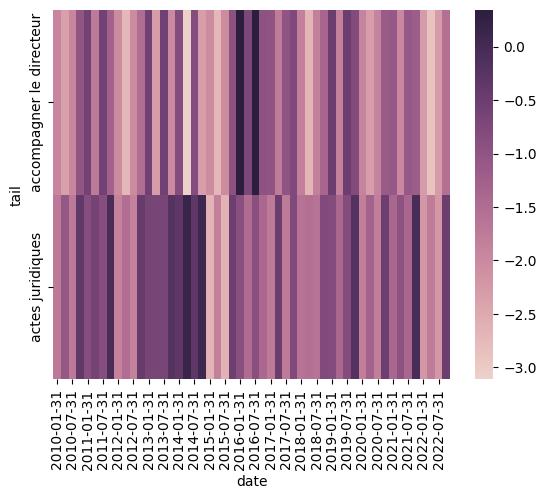

In [41]:
sns.heatmap(example_piv, cmap=sns.cubehelix_palette(as_cmap=True), annot=False)

## Tests

In [42]:
data_path = 'data' + '/edukg'
ent_df = pd.read_csv(data_path + '/entity2id.txt', sep='\t',
                 header=None, names=['ent', 'id'])

In [43]:
ent_df

,ent,id
0,job_titles_2235,0
1,job_titles_7358,1
2,job_titles_9593,2
3,coursera_H_SYjXVXEeuBTg7vUdMe9w,3
4,coursera_Qv4OEHIuEeuBTg7vUdMe9w,4
...,...,...
13341,job_titles_5022,13341
13342,hard_skills_32131,13342
13343,coursera_69sweSMjEeuCghIYeOsGoQ,13343
13344,job_titles_5421,13344


In [44]:
data_path = 'data' + '/edukg'

ent_names = pd.read_csv(data_path + '/all_ent_names.csv')

In [45]:
ent_names

,ent_id,ent_name
0,job_titles_0,Chargés de Clientèle en Assistance Technique
1,job_titles_1,Consultant Junior
2,job_titles_2,Directeur Administratif et Financier
3,job_titles_3,Sales Managers Hispanophones
4,job_titles_4,Sales Managers Francophones
...,...,...
55713,coursera_QJlWBW30Eeq2hwr9iuARBQ,Strategic Sourcing
55714,coursera_XSLeWQ6pEeu9ZBLzQTJEhw,The Korean Alphabet: An Introduction to Hangeul
55715,coursera_7ErrkakwEeyxDg4ukgkVlw,Looker Functions and Operators
55716,coursera_xcqAU7oaEeq1DQ4cuiU-Sw,Build a film club web app on Google AppEngine


In [46]:
ent_names_map = dict(zip(ent_names['ent_id'], ent_names['ent_name']))

In [47]:
ent_names_map

{'job_titles_0': 'Chargés de Clientèle en Assistance Technique',
 'job_titles_1': 'Consultant Junior',
 'job_titles_2': 'Directeur Administratif et Financier',
 'job_titles_3': 'Sales Managers Hispanophones',
 'job_titles_4': 'Sales Managers Francophones',
 'job_titles_5': 'Technical Support Managers',
 'job_titles_6': 'Project Manager (anglais courant)',
 'job_titles_7': 'Quality Process Manager (anglais courant)',
 'job_titles_8': 'Responsable Ressources Humaines',
 'job_titles_9': 'Chef Comptable',
 'job_titles_10': 'Comptable',
 'job_titles_11': 'Assistante du Directeur Financier',
 'job_titles_12': 'Contrôleur de Gestion',
 'job_titles_13': 'Développeur .NET',
 'job_titles_14': 'Chef de Projet Développement .NET',
 'job_titles_15': 'Développeur PHP / MYSQL',
 'job_titles_16': 'Chef de Projet .NET',
 'job_titles_17': 'Ingénieur Développeur .NET',
 'job_titles_18': 'Attachés commerciaux B2B',
 'job_titles_19': 'Rédacteur Animateur',
 'job_titles_20': 'Responsable Informatique',
 'jo

In [48]:
ent_df['ent'].map(ent_names_map)

0                  Business Controller   Réf. 17.R.014.A.R
1                                 Chef de Projet TMA AS400
2                                   Stagiaires Recrutement
3        Identify One Source of Truth with a Project Wa...
4        Visual Basic Programming: Inheritance and Poly...
                               ...                        
13341                                    Production Leader
13342                              outils de développement
13343                              Digitale Transformation
13344                                            Analystes
13345                  mener des négociations commerciales
Name: ent, Length: 13346, dtype: object

In [49]:
get_ent_data()[1]

,kg_id,model_id
0,_favors,0
1,_has,1
2,_co_occurs_with,2
3,_by,3
4,_requires,4
5,_needs,5
6,_provides,6
7,_belongs_to,7
8,_acquired_by,8
9,_locates,9


In [50]:
pd.read_csv(data_path + '/relation2id.txt', sep='\t',
                     header=None, names=['kg_id', 'model_id'])

,kg_id,model_id
0,_favors,0
1,_has,1
2,_co_occurs_with,2
3,_by,3
4,_requires,4
5,_needs,5
6,_provides,6
7,_belongs_to,7
8,_acquired_by,8
9,_locates,9


In [51]:

somelists = [
   [1, 2, 3],
   ['a', 'b'],
   [4, 5]
]
for element in itertools.product(*somelists):
    print(element)

(1, 'a', 4)
(1, 'a', 5)
(1, 'b', 4)
(1, 'b', 5)
(2, 'a', 4)
(2, 'a', 5)
(2, 'b', 4)
(2, 'b', 5)
(3, 'a', 4)
(3, 'a', 5)
(3, 'b', 4)
(3, 'b', 5)


In [52]:
list(itertools.product(*somelists))

[(1, 'a', 4),
 (1, 'a', 5),
 (1, 'b', 4),
 (1, 'b', 5),
 (2, 'a', 4),
 (2, 'a', 5),
 (2, 'b', 4),
 (2, 'b', 5),
 (3, 'a', 4),
 (3, 'a', 5),
 (3, 'b', 4),
 (3, 'b', 5)]

In [53]:
def generate_timestamps():
    times = []
    ts = datetime(2017, 7, 17, 9, 10, 0)
    while ts <= datetime(2023, 7, 17, 15, 30, 0):
        times.append(time(ts.hour, ts.minute, ts.second))
        ts += timedelta(hours=3)
    return times

In [54]:
generate_timestamps()

[datetime.time(9, 10),
 datetime.time(12, 10),
 datetime.time(15, 10),
 datetime.time(18, 10),
 datetime.time(21, 10),
 datetime.time(0, 10),
 datetime.time(3, 10),
 datetime.time(6, 10),
 datetime.time(9, 10),
 datetime.time(12, 10),
 datetime.time(15, 10),
 datetime.time(18, 10),
 datetime.time(21, 10),
 datetime.time(0, 10),
 datetime.time(3, 10),
 datetime.time(6, 10),
 datetime.time(9, 10),
 datetime.time(12, 10),
 datetime.time(15, 10),
 datetime.time(18, 10),
 datetime.time(21, 10),
 datetime.time(0, 10),
 datetime.time(3, 10),
 datetime.time(6, 10),
 datetime.time(9, 10),
 datetime.time(12, 10),
 datetime.time(15, 10),
 datetime.time(18, 10),
 datetime.time(21, 10),
 datetime.time(0, 10),
 datetime.time(3, 10),
 datetime.time(6, 10),
 datetime.time(9, 10),
 datetime.time(12, 10),
 datetime.time(15, 10),
 datetime.time(18, 10),
 datetime.time(21, 10),
 datetime.time(0, 10),
 datetime.time(3, 10),
 datetime.time(6, 10),
 datetime.time(9, 10),
 datetime.time(12, 10),
 datetime.tim

In [55]:
list(pd.date_range(start='1/1/2005', end='1/08/2023', freq='3M').astype(str))

['2005-01-31',
 '2005-04-30',
 '2005-07-31',
 '2005-10-31',
 '2006-01-31',
 '2006-04-30',
 '2006-07-31',
 '2006-10-31',
 '2007-01-31',
 '2007-04-30',
 '2007-07-31',
 '2007-10-31',
 '2008-01-31',
 '2008-04-30',
 '2008-07-31',
 '2008-10-31',
 '2009-01-31',
 '2009-04-30',
 '2009-07-31',
 '2009-10-31',
 '2010-01-31',
 '2010-04-30',
 '2010-07-31',
 '2010-10-31',
 '2011-01-31',
 '2011-04-30',
 '2011-07-31',
 '2011-10-31',
 '2012-01-31',
 '2012-04-30',
 '2012-07-31',
 '2012-10-31',
 '2013-01-31',
 '2013-04-30',
 '2013-07-31',
 '2013-10-31',
 '2014-01-31',
 '2014-04-30',
 '2014-07-31',
 '2014-10-31',
 '2015-01-31',
 '2015-04-30',
 '2015-07-31',
 '2015-10-31',
 '2016-01-31',
 '2016-04-30',
 '2016-07-31',
 '2016-10-31',
 '2017-01-31',
 '2017-04-30',
 '2017-07-31',
 '2017-10-31',
 '2018-01-31',
 '2018-04-30',
 '2018-07-31',
 '2018-10-31',
 '2019-01-31',
 '2019-04-30',
 '2019-07-31',
 '2019-10-31',
 '2020-01-31',
 '2020-04-30',
 '2020-07-31',
 '2020-10-31',
 '2021-01-31',
 '2021-04-30',
 '2021-07-

In [56]:
read_csv(data_path + '/train.txt',
                   sep='\t', header=None, names=['from', 'rel', 'to', 'start_time', 'end_time']).dtypes

from           object
rel            object
to             object
start_time     object
end_time      float64
dtype: object